# IMPORT LIBRARIES

In [180]:
pip install pmdarima

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import pickle
# Google services
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
drive.mount('/content/drive')
from google.auth import default
from google.colab import auth
# Authenticate
auth.authenticate_user()
creds, _ = default()
# Authorize gspread
gc = gspread.authorize(creds)
# Cài đặt hiển thị rộng hơn cho DataFrame
pd.set_option('display.width', 1200)  # Độ rộng tối đa
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
pd.set_option('display.max_rows', None)  # Hiển thị tất cả các hàng

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD DATA

About Dataset: NMV (Sale) vnd

In [182]:
# Colab
spreadsheet_id = "1R0_tAkBd4w6lR6krI0Zb4Cn1Hc3O_-xygPIE9K_iaZ0"  # Replace with your Spreadsheet ID
sheet_name = "data"  # Change to your sheet name

# Open the Google Spreadsheet
sh = gc.open_by_key(spreadsheet_id)
worksheet = sh.worksheet(sheet_name)

# Get all data
data = worksheet.get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]  # Use first row as headers
df = df[1:]              # Skip the header row in the data

df['nmv'] = pd.to_numeric(df['nmv']) # Convert 'nmv' column to numeric, handling errors

# Rename columns and keep only Month and Sales
df = df.rename(columns={'date_key': 'Time', 'nmv': 'Sales'})
df = df[['Time', 'Sales']]
df.set_index('Time', inplace=True)
pd.set_option('display.float_format', '{:.2f}'.format) # Set pandas display options to avoid scientific notation
print(df)

0                  Sales
Time                    
2023-09-01  196088478048
2023-10-01  193806971443
2023-11-01  185357688406
2023-12-01  169696397949
2024-01-01  148097344016
2024-02-01  101453296824
2024-03-01  132078849895
2024-04-01  104406546191
2024-05-01  114427136014
2024-06-01  105953337425
2024-07-01  126744900165
2024-08-01  139829987390
2024-09-01  138905000000
2024-10-01  134309000000
2024-11-01   99099000000
2024-12-01   94011000000
2025-01-01   76265000000
2025-02-01   72039000000


# EXPLORE DATA ANALYSIS

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 2023-09-01 to 2025-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   18 non-null     int64
dtypes: int64(1)
memory usage: 288.0+ bytes


In [184]:
print(df.describe(include='all'))

0               Sales
count           18.00
mean  129587162987.00
std    37885939953.08
min    72039000000.00
25%   102191609165.75
50%   129411875030.00
75%   146030504859.50
max   196088478048.00


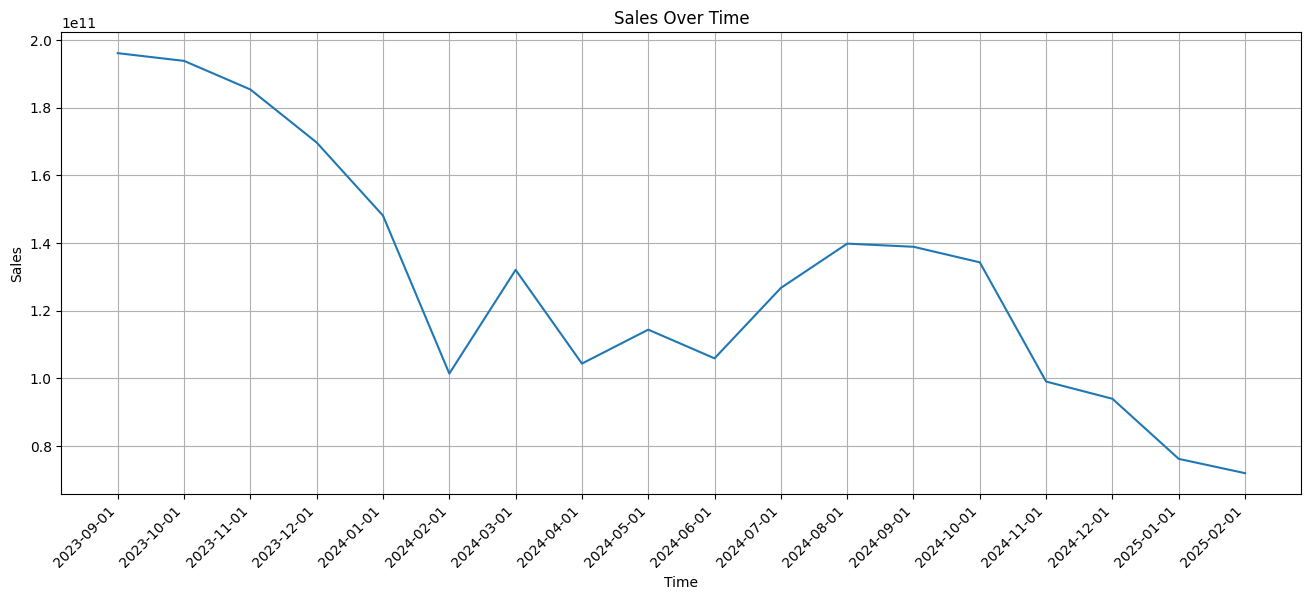

In [185]:
# Plotting the Sales data
plt.figure(figsize=(16, 6))
plt.plot(df['Sales'])
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.grid(True)
plt.xticks(rotation=45, ha='right') # Rotate labels 45 degrees, align right
plt.show()

# INPUT

In [186]:
freq = 4 # input frequency seasonal
lags_1 = 14
lags_2 = 8
time_step = 13 # step time prediction

# SEASONALITY & STATIONATIRY

<ipython-input-187-f678b951f0f7>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method='ffill')


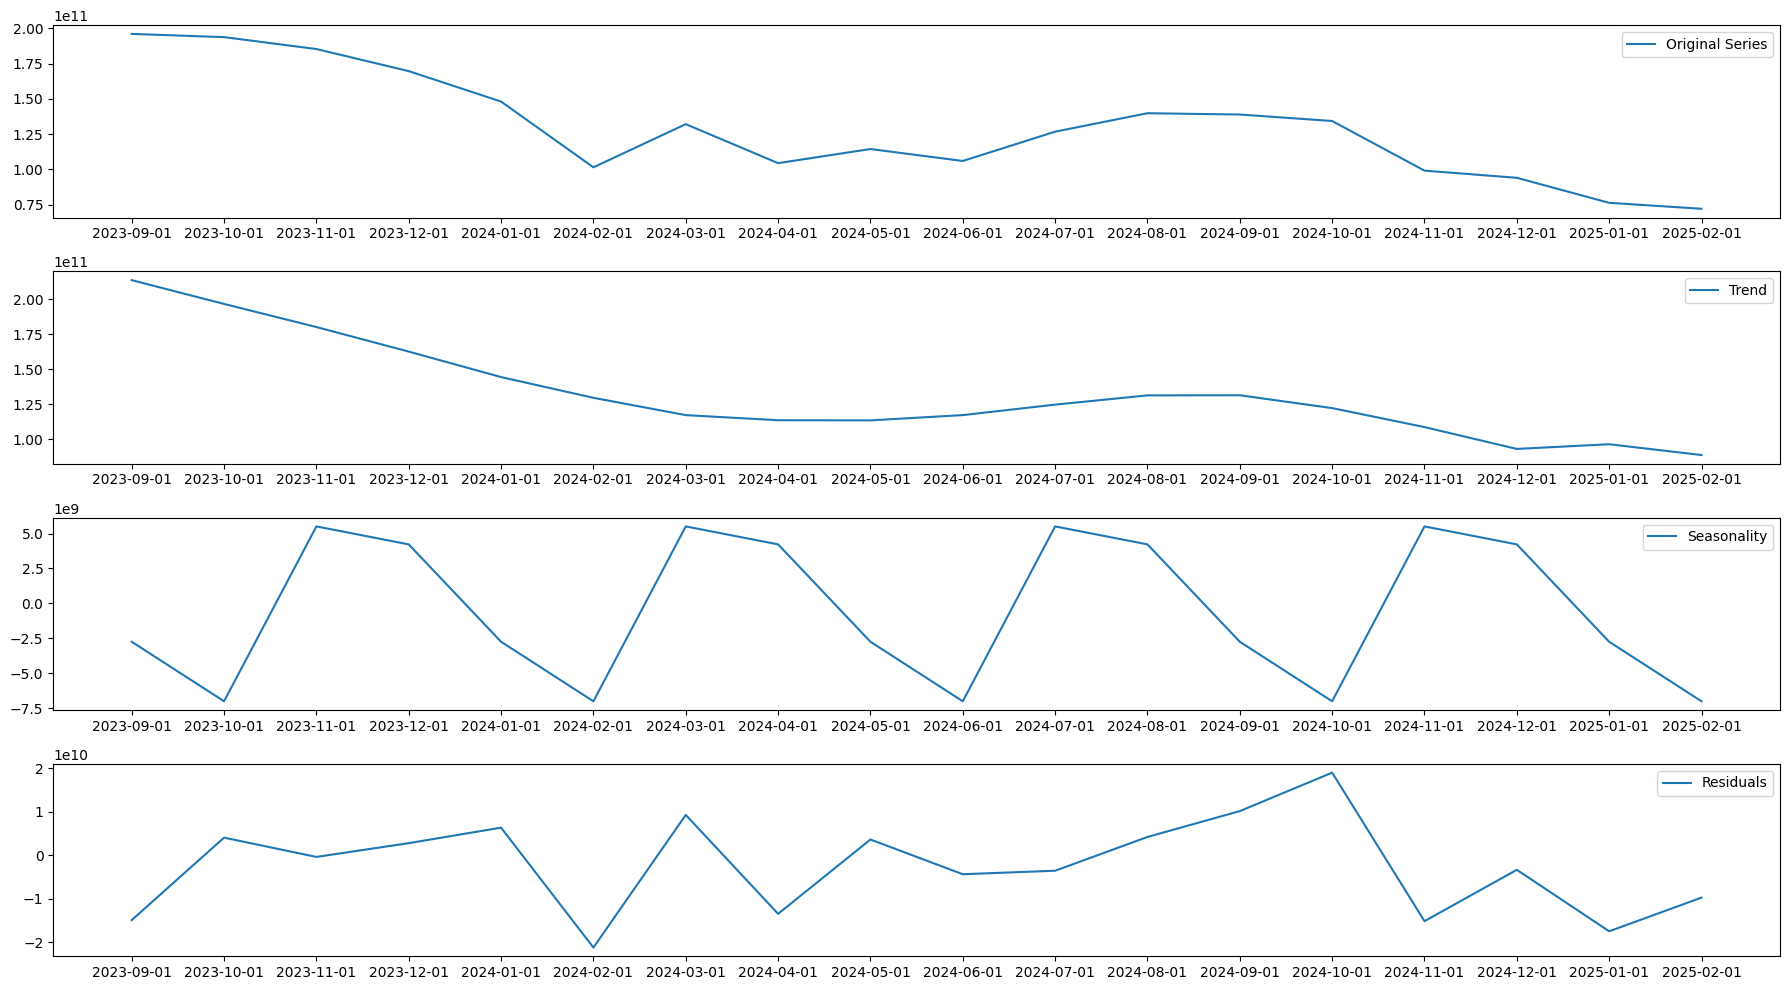


ADF Statistic: -1.9845533853036115
p-value: 0.2933866989368549
Dữ liệu có tính dừng



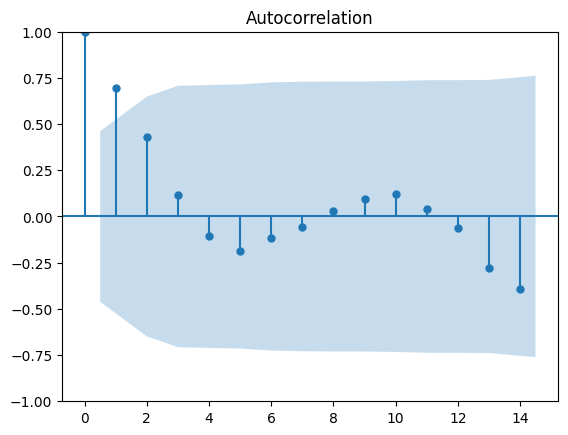

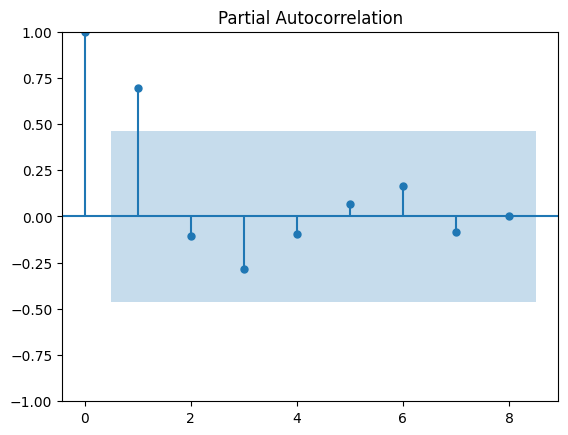


Có tính chu kỳ (seasonality_strength=0.14), nên dùng seasonal=True.
Seasonal = True


In [187]:
def check_seasonality(time_series, freq=None):
    """
    Kiểm tra xem chuỗi thời gian có tính chu kỳ không.

    Params:
        time_series: Chuỗi dữ liệu dạng pandas Series.
        freq: Tần suất chu kỳ (nếu biết trước, có thể đặt, ví dụ: 12 cho dữ liệu hàng tháng).

    Returns:
        True nếu có seasonality, False nếu không.
    """
    # Handle missing values by filling with the previous valid value (forward fill)
    time_series = time_series.fillna(method='ffill')

    # Bước 1: Phân rã chuỗi thời gian (Seasonal Decomposition)
    decomposition = seasonal_decompose(time_series, period=freq, model='additive', extrapolate_trend='freq')
    seasonal_component = decomposition.seasonal

    # Vẽ thành phần chu kỳ
    plt.figure(figsize=(18, 10))
    plt.subplot(411)
    plt.plot(time_series, label='Original Series')
    plt.legend()
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()
    plt.subplot(413)
    plt.plot(seasonal_component, label='Seasonality')
    plt.legend()
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print()

    # Bước 2: Kiểm tra ADF Test (Stationarity Test)
    adf_result = adfuller(time_series.dropna())
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")

    if adf_result[1] > 0.05:
        print("Dữ liệu có tính dừng")
    else:
        print("Dữ liệu không có tính dừng")
    print()

    # Bước 3: Kiểm tra Auto-Correlation Function (ACF)
    plot_acf(time_series.dropna(), lags=lags_1)
    plt.show()

    plot_pacf(time_series.dropna(), lags=lags_2)
    plt.show()
    print()

    # Bước 4: Đánh giá độ biến động của thành phần chu kỳ
    seasonality_strength = np.std(seasonal_component) / np.std(time_series)

    if seasonality_strength > 0.1:
        print(f"Có tính chu kỳ (seasonality_strength={seasonality_strength:.2f}), nên dùng seasonal=True.")
        return True
    else:
        print(f"Không có tính chu kỳ rõ ràng (seasonality_strength={seasonality_strength:.2f}), nên dùng seasonal=False.")
        return False
    print()
# Kiểm tra seasonality
should_use_seasonal = check_seasonality(df['Sales'], freq=freq) # freq=freq
print(f"Seasonal = {should_use_seasonal}")

# BUILDING AN ARIMA MODEL

## Automatically select the best parameters using auto_arima:
auto_arima sẽ tự xử lý differencing nếu dữ liệu có stationarity = false

In [188]:
# Dùng auto_arima để chọn tham số
if should_use_seasonal == True:
  model_auto = auto_arima(df['Sales'], seasonal=True, m=freq, trace=True, suppress_warnings=True, stepwise=True)
else:
  model_auto = auto_arima(df['Sales'], seasonal=False, trace=True, suppress_warnings=True, stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=853.291, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=857.006, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=860.579, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=860.839, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=857.365, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=851.519, Time=1.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=866.121, Time=2.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,2)[4] intercept   : AIC=853.369, Time=1.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=863.172, Time=0.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[4] intercept   : AIC=854.263, Time=0.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[4] intercept   : AIC=860.207, Time=0.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[4] intercept   : AIC=860.406, Time=0.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,1)[4] intercept   : AIC=851.542, Time=0.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,1)[4] intercept   : AIC=849.239, Time=2.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[4] intercept   : AIC=872.426, Time=0.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,1)[4] intercept   : AIC=inf, Time=1.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,2)[4] intercept   : AIC=873.196, Time=3.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,0)[4] intercept   : AIC=859.199, Time=2.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,2)[4] intercept   : AIC=inf, Time=1.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,1)[4] intercept   : AIC=863.145, Time=0.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,1)[4] intercept   : AIC=851.147, Time=0.57 sec
 ARIMA(2,1,3)(0,0,1)[4]             : AIC=849.161, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[4]             : AIC=inf, Time=0.12 sec
 ARIMA(2,1,3)(1,0,1)[4]             : AIC=inf, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,2)[4]             : AIC=850.895, Time=0.23 sec
 ARIMA(2,1,3)(1,0,0)[4]             : AIC=inf, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,2)[4]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,3)(0,0,1)[4]             : AIC=857.898, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[4]             : AIC=inf, Time=0.14 sec
 ARIMA(3,1,3)(0,0,1)[4]             : AIC=inf, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[4]             : AIC=859.631, Time=0.07 sec
 ARIMA(3,1,2)(0,0,1)[4]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,1,3)(0,0,1)[4]          
Total fit time: 24.953 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   18
Model:             SARIMAX(2, 1, 3)x(0, 0, [1], 4)   Log Likelihood                -417.581
Date:                             Sat, 08 Mar 2025   AIC                            849.161
Time:                                     04:09:10   BIC                            854.994
Sample:                                 09-01-2023   HQIC                           849.741
                                      - 02-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Training ARIMA model:

In [189]:
# Xây dựng mô hình với tham số từ auto_arima
if should_use_seasonal == True:
  model = SARIMAX(df['Sales'], order=model_auto.order, seasonal_order=model_auto.seasonal_order)
  model_fit = model.fit()
else:
  model = ARIMA(df['Sales'], order=model_auto.order)
  model_fit = model.fit()

# Tóm tắt kết quả mô hình
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   18
Model:             SARIMAX(2, 1, 3)x(0, 0, [1], 4)   Log Likelihood                -417.581
Date:                             Sat, 08 Mar 2025   AIC                            849.161
Time:                                     04:09:10   BIC                            854.994
Sample:                                 09-01-2023   HQIC                           849.741
                                      - 02-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5346      0.233     -6.590      0.000      -1.991      -1.078
ar.L2         -0.6282      

# FORECAST AND ASSESSMENT

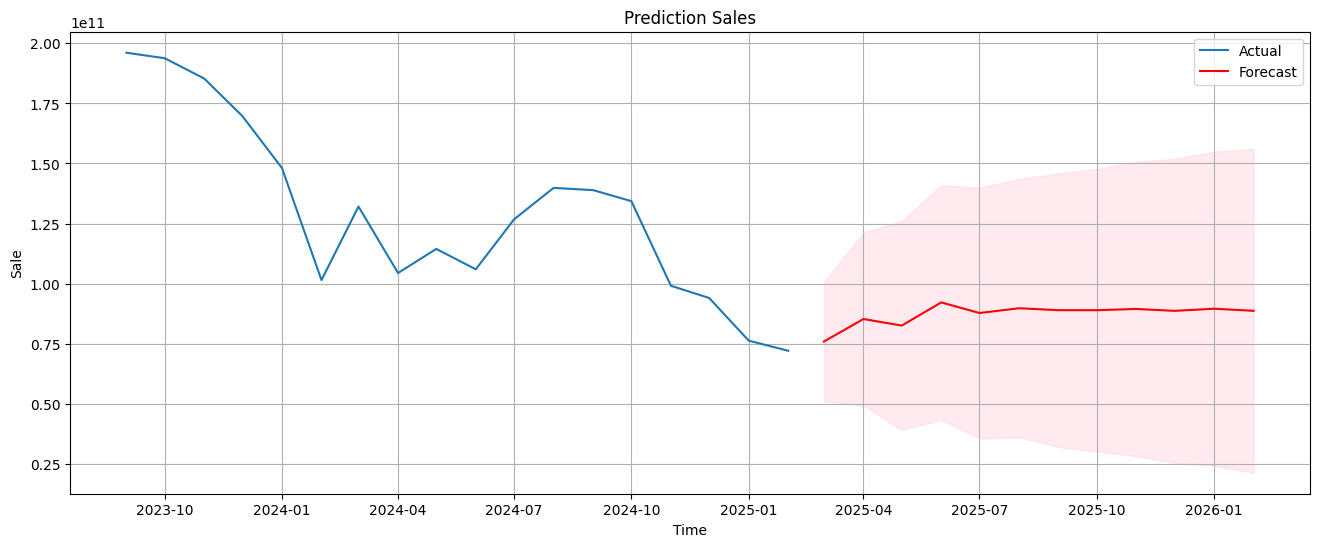


                 Forecast    Lower Bound     Upper Bound
2025-03-01 75891508048.03 50938156790.82 100844859305.24
2025-04-01 85258177194.59 49280266540.49 121236087848.68
2025-05-01 82526489725.95 39067122873.96 125985856577.95
2025-06-01 92163957715.87 43344775819.82 140983139611.93
2025-07-01 87755408241.61 35568635264.09 139942181219.13
2025-08-01 89736470318.61 35963210223.08 143509730414.15
2025-09-01 88936032194.01 31993554482.56 145878509905.47
2025-10-01 88920008212.92 30139152858.62 147700863567.21
2025-11-01 89447394509.34 28164722966.60 150730066052.09
2025-12-01 88648114435.20 25380515461.79 151915713408.61
2026-01-01 89543439936.06 24168122355.64 154918757516.48
2026-02-01 88671509867.39 21286106831.29 156056912903.49


In [190]:
# Dự báo cho tương lai (12 tháng tiếp theo)
forecast = model_fit.get_forecast(steps=time_step)
df.index = pd.to_datetime(df.index)
forecast_index = pd.date_range(df.index[-1], periods=time_step, freq='MS')  #freq='M' last day of monthly, 'MS' first day of monthly, 'YS' yearly
# forecast_index = np.arange(len(df)+1, len(df) + time_step+1)

forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean,
    'Lower Bound': forecast.conf_int()['lower Sales'],
    'Upper Bound': forecast.conf_int()['upper Sales']
}, index=forecast_index)

# Vẽ biểu đồ dự báo
plt.figure(figsize=(16, 6))
plt.plot(df['Sales'], label='Actual')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red') # Explicitly pass the index of forecast_df for the x-axis
plt.fill_between(forecast_df.index,
                 forecast_df['Lower Bound'],
                 forecast_df['Upper Bound'], color='pink', alpha=0.3)
plt.title('Prediction Sales')
plt.xlabel('Time')
plt.ylabel('Sale')
plt.legend()
plt.grid()
plt.show()
print()

print(forecast_df[1:])

# MODEL EVALUATION

In [191]:
# Tính toán MAE và RMSE
actual_values = df['Sales'][-time_step+1:]
forecast_values = forecast_df['Forecast'][1:time_step]

mae = mean_absolute_error(actual_values, forecast_values)
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 29199345523.94289
RMSE: 34025659777.13307


In [192]:
print(actual_values)
print()
print(forecast_values)

Time
2024-03-01    132078849895
2024-04-01    104406546191
2024-05-01    114427136014
2024-06-01    105953337425
2024-07-01    126744900165
2024-08-01    139829987390
2024-09-01    138905000000
2024-10-01    134309000000
2024-11-01     99099000000
2024-12-01     94011000000
2025-01-01     76265000000
2025-02-01     72039000000
Name: Sales, dtype: int64

2025-03-01   75891508048.03
2025-04-01   85258177194.59
2025-05-01   82526489725.95
2025-06-01   92163957715.87
2025-07-01   87755408241.61
2025-08-01   89736470318.61
2025-09-01   88936032194.01
2025-10-01   88920008212.92
2025-11-01   89447394509.34
2025-12-01   88648114435.20
2026-01-01   89543439936.06
2026-02-01   88671509867.39
Freq: MS, Name: Forecast, dtype: float64


# MODEL DEPLOYMENT

In [193]:
# Lưu mô hình
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

# Tải lại mô hình khi cần
with open('arima_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Dự báo lại với mô hình đã lưu
forecast_loaded = loaded_model.get_forecast(steps=12)
print(forecast_loaded.predicted_mean)

2025-03-01   75891508048.03
2025-04-01   85258177194.59
2025-05-01   82526489725.95
2025-06-01   92163957715.87
2025-07-01   87755408241.61
2025-08-01   89736470318.61
2025-09-01   88936032194.01
2025-10-01   88920008212.92
2025-11-01   89447394509.34
2025-12-01   88648114435.20
2026-01-01   89543439936.06
2026-02-01   88671509867.39
Freq: MS, Name: predicted_mean, dtype: float64


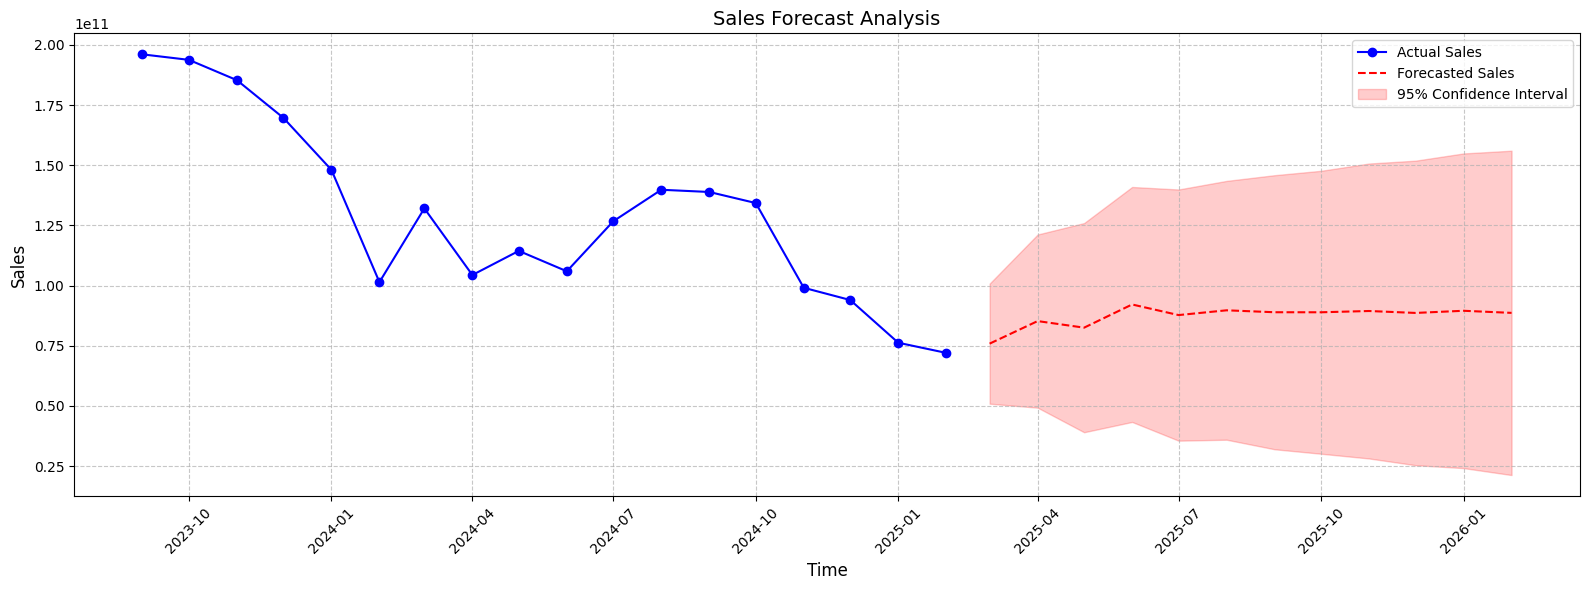

In [194]:
plt.figure(figsize=(16, 6))

# Plot actual values
plt.plot(df.index, df['Sales'], label='Actual Sales', color='blue', marker='o')

# Plot forecasted values
plt.plot(forecast_df.index[1:], forecast_df['Forecast'][1:], label='Forecasted Sales', color='red', linestyle='--')

# Add confidence intervals
plt.fill_between(forecast_df.index[1:],
         forecast_df['Lower Bound'][1:],
         forecast_df['Upper Bound'][1:],
         color='red', alpha=0.2, label='95% Confidence Interval')

plt.title('Sales Forecast Analysis', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [195]:
# Create a comparison DataFrame
comparison_df = pd.DataFrame({
  'Actual Sales': df['Sales'],
  'Forecasted Sales': pd.Series(forecast_df['Forecast'], index=forecast_df.index)
})

# Add confidence intervals
comparison_df['Lower Bound'] = pd.Series(forecast_df['Lower Bound'], index=forecast_df.index)
comparison_df['Upper Bound'] = pd.Series(forecast_df['Upper Bound'], index=forecast_df.index)

# Format numbers for better readability
pd.options.display.float_format = '{:,.0f}'.format

print("\nComparison of Actual and Forecasted Sales:")
print("==========================================")
print(comparison_df)

# Print some basic statistics
print("\nSummary Statistics:")
print("==================")
print(f"Average Actual Sales: {df['Sales'].mean():,.0f}")
print(f"Average Forecasted Sales: {forecast_df['Forecast'].mean():,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")


Comparison of Actual and Forecasted Sales:
              Actual Sales  Forecasted Sales    Lower Bound     Upper Bound
2023-09-01 196,088,478,048               NaN            NaN             NaN
2023-10-01 193,806,971,443               NaN            NaN             NaN
2023-11-01 185,357,688,406               NaN            NaN             NaN
2023-12-01 169,696,397,949               NaN            NaN             NaN
2024-01-01 148,097,344,016               NaN            NaN             NaN
2024-02-01 101,453,296,824               NaN            NaN             NaN
2024-03-01 132,078,849,895               NaN            NaN             NaN
2024-04-01 104,406,546,191               NaN            NaN             NaN
2024-05-01 114,427,136,014               NaN            NaN             NaN
2024-06-01 105,953,337,425               NaN            NaN             NaN
2024-07-01 126,744,900,165               NaN            NaN             NaN
2024-08-01 139,829,987,390               NaN